In [105]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean, median, mode

## Offensive Language Identification

### Data Loading

In [115]:
BASE_DIR = "/home/data/eacl/ta/original_dataset"

In [116]:
train = pd.read_csv(f"{BASE_DIR}/tamil_offensive_full_train.csv", sep="\t", names=['sentence', 'label', 'extra'])

train.drop(columns=['extra'], inplace=True)

In [117]:
train

,sentence,label
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive
...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,Not_offensive
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",Not_offensive
35136,Just 3k likes for 300k likes,Not_offensive
35137,Aaloo le lo. Kanda le lo.,not-Tamil


In [118]:
train['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [120]:
valid = pd.read_csv(f"{BASE_DIR}/tamil_offensive_full_dev.csv", sep="\t", header=None, names=['sentence', 'label', 'extra'])

valid.drop(columns=['blah'], inplace=True)


In [123]:
test = pd.read_csv(f"{BASE_DIR}/tamil_offensive_full_test.csv", sep="\t", header=None, names=['sentence'])


In [124]:
test

,sentence
0,14.12.2018 epo trailer pathutu irken ... Semay...
1,Paka thana poro movie la Enna irukunu
2,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Suriya anna vera level anna mass
4,suma kaththaatha da sound over a pooda kudaath...
...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...
4388,Babu mele ko ye song sunke kuch yesa feel hua ...
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...
4390,Vijay's all movies look like same.


### Transliteration

In [206]:
from libindic.transliteration import getInstance

In [207]:
transliterator = getInstance()


In [19]:
sent = "கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁"

In [25]:
sent = "في قناتي على اليوتيوب ( كل ماتتمناه 18 ) ًاشت..."

In [26]:
transliterator.transliterate(sent, "en_US")

' في قناتي على اليوتيوب ( كل ماتتمناه 18 ) ًاشت...'

In [28]:
train['sentence'] = train['sentence'].apply(lambda x: transliterator.transliterate(x, "en_US"))

In [219]:
train

,sentence,label,token_count
0,movie vara level la Erika poguthu,Not_offensive,6
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil,11
2,Padam nalla comedy padama irukum polaye..,Not_offensive,7
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive,12
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive,6
...,...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,Not_offensive,19
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",Not_offensive,10
35136,Just 3k likes for 300k likes,Not_offensive,6
35137,Aaloo le lo. Kanda le lo.,not-Tamil,8


In [34]:
train.to_csv(f"{BASE_DIR}/tamil_offensive_full_train_transliterated.csv", index=False)

In [33]:
valid['sentence'] = valid['sentence'].apply(lambda x: transliterator.transliterate(x, "en_US"))

In [36]:
valid.to_csv(f"{BASE_DIR}/tamil_offensive_full_dev_transliterated.csv", index=False)


In [41]:
test = pd.read_csv(f"{BASE_DIR}/tamil_offensive_full_test.csv", sep="\t", header=None, names=['sentence'])
test.head()

,sentence
0,14.12.2018 epo trailer pathutu irken ... Semay...
1,Paka thana poro movie la Enna irukunu
2,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Suriya anna vera level anna mass
4,suma kaththaatha da sound over a pooda kudaath...


In [42]:
test['sentence'] = test['sentence'].apply(lambda x: transliterator.transliterate(x, "en_US"))

In [44]:
test.to_csv(f"{BASE_DIR}/tamil_offensive_full_test_transliterated.csv", index=False)

### Dataset Exploration

In [200]:
train.shape, valid.shape, test.shape

((35139, 3), (4388, 4), (4392, 2))

In [125]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

In [126]:
only_roman_chars("विकिपीडिया")

False

In [136]:
def get_roman_char_count_distribution(df):
    count = 0
    for index, row in df.iterrows():
        if not only_roman_chars(row['sentence']):
            count +=1
    total_rows = df.shape[0]
    not_roman = count/total_rows
    roman = (total_rows - count)/total_rows
    return roman, not_roman

In [129]:
def get_class_distribution(df):
    D = Counter(df['label'])
    plt.rcParams["figure.figsize"] = (3,3)
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()
    
    print('Min no. of sentences: ', min(D.values()))
    print('Max no. of sentences: ', max(D.values()))
    print('Avg no. of sentences: ', mean(D.values()))
    print('Median of sentences: ', median(D.values()))

In [130]:
nlp = spacy.load("xx_ent_wiki_sm")
def tokenize(s: str):
    doc = nlp(s)

    return [token.text for token in doc]

In [131]:
tokenize("I am Dr.Megha.")

['I', 'am', 'Dr', '.', 'Megha', '.']

In [132]:
def get_token_level_distribution(df):
    len_of_tokens = []
    for index, row in df.iterrows():
        tokens = tokenize((row['sentence']).lower())
        len_of_tokens.append(len(tokens))
    print('Min no. of tokens: ', min(len_of_tokens))
    print('Max no. of tokens: ', max(len_of_tokens))
    print('Avg no. of tokens: ', mean(len_of_tokens))
    print('Median of no. of tokens: ', median(len_of_tokens))

In [137]:
get_roman_char_count_distribution(train), get_roman_char_count_distribution(valid), get_roman_char_count_distribution(test)


((0.8041207774837076, 0.19587922251629244),
 (0.8101640838650866, 0.1898359161349134),
 (0.8119307832422586, 0.18806921675774135))

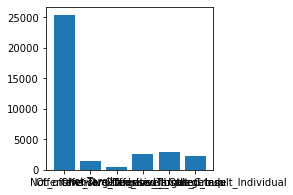

Min no. of sentences:  454
Max no. of sentences:  25425
Avg no. of sentences:  5856.5
Median of sentences:  2450.0


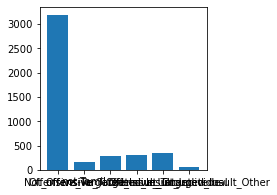

Min no. of sentences:  65
Max no. of sentences:  3193
Avg no. of sentences:  731.3333333333334
Median of sentences:  301.0


(None, None)

In [138]:
get_class_distribution(train), get_class_distribution(valid)

In [57]:
train['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [147]:
# get_token_level_distribution(train), get_token_level_distribution(valid), get_token_level_distribution(test)

In [140]:
def get_token_count(sent):
    doc = nlp(sent)
    tokens = [token for token in doc]
    return len(tokens)

In [141]:
train['token_count'] = train['sentence'].apply(lambda x: get_token_count(x))

In [142]:
valid['token_count'] = valid['sentence'].apply(lambda x: get_token_count(x))

In [143]:
test['token_count'] = test['sentence'].apply(lambda x: get_token_count(x))

In [144]:
train['token_count'].mean(), train['token_count'].max(), train['token_count'].min(), train['token_count'].median()

(12.040866273940635, 183, 1, 9.0)

In [145]:
valid['token_count'].mean(), valid['token_count'].max(), valid['token_count'].min(), valid['token_count'].median()

(12.028942570647219, 93, 2, 9.0)

In [146]:
test['token_count'].mean(), test['token_count'].max(), test['token_count'].min(), test['token_count'].median()

(11.896857923497267, 138, 1, 9.0)

<AxesSubplot:ylabel='Frequency'>

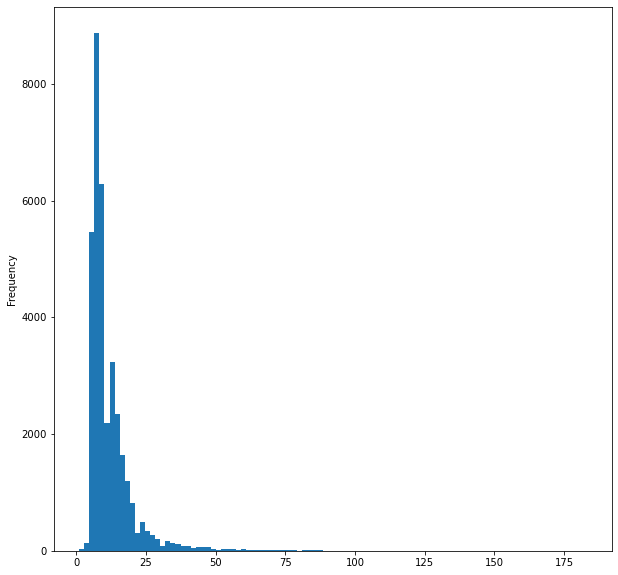

In [197]:
train['token_count'].plot.hist(bins=100, alpha=1)

<AxesSubplot:ylabel='Frequency'>

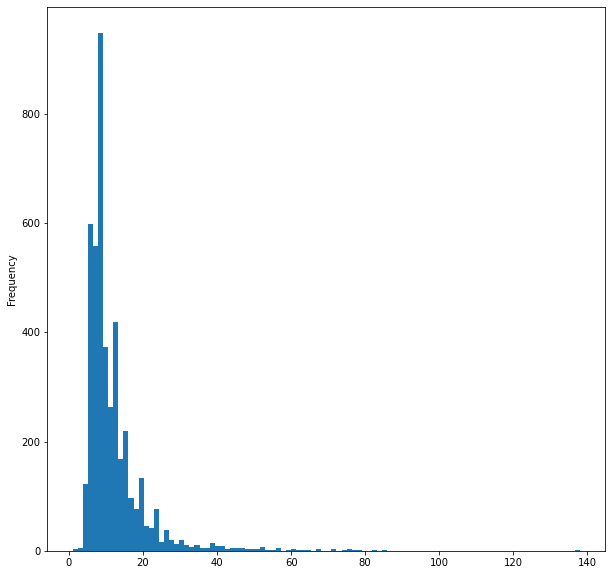

In [198]:
test['token_count'].plot.hist(bins=100, alpha=1)

<AxesSubplot:ylabel='Frequency'>

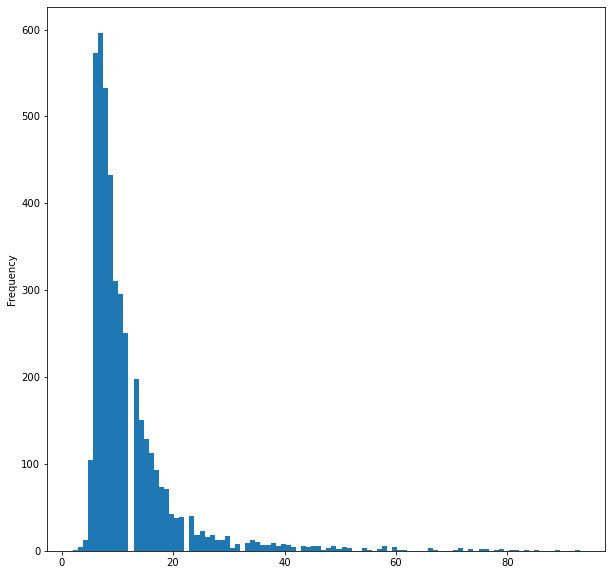

In [199]:
valid['token_count'].plot.hist(bins=100, alpha=1)

## Hope Speech Detection

### Data Loading

In [156]:
hope_train = pd.read_csv(f"{BASE_DIR}/tamil_hope_first_train.csv", sep="\t", names=['sentence', 'label', 'extra'])
hope_train.drop(columns=['extra'], inplace=True)

In [158]:
hope_dev = pd.read_csv(f"{BASE_DIR}/tamil_hope_first_dev.csv", sep="\t", names=['sentence', 'label', 'extra'])
hope_dev.drop(columns=['extra'], inplace=True)

In [163]:
hope_test = pd.read_csv(f"{BASE_DIR}/tamil_hope_test.csv", sep="\t", names=['sentence', 'label'])


In [164]:
hope_test

,sentence,label
0,text;label;,NaN
1,Konjam methuva pesuninganna nalarukum bro...;H...,NaN
2,Sema bro............. தமிழன் என்று சொல்லடா தலை...,NaN
3,9.52 mg bro plz crrt pannunga bro;Hope_speech;,NaN
4,Superb anna;Non_hope_speech;,NaN
...,...,...
2016,Solunga bro parvala;Hope_speech;,NaN
2017,Madangowri anna 9.53s time note pannunga Indi...,NaN
2018,Enna nadu vanthu vaccine kudaka matadragalo an...,NaN
2019,Yes..ipdii thaan avangaluku bathil kudukanu......,NaN


### Data Exploration

In [166]:
get_roman_char_count_distribution(hope_train), get_roman_char_count_distribution(hope_dev), get_roman_char_count_distribution(hope_test)


((0.8399752475247525, 0.16002475247524753),
 (0.8389494549058474, 0.16105054509415262),
 (0.8485898070262247, 0.15141019297377536))

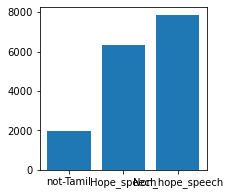

Min no. of sentences:  1961
Max no. of sentences:  7872
Avg no. of sentences:  5386.666666666667
Median of sentences:  6327


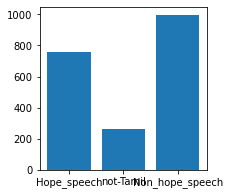

Min no. of sentences:  263
Max no. of sentences:  998
Avg no. of sentences:  672.6666666666666
Median of sentences:  757


(None, None)

In [167]:
get_class_distribution(hope_train), get_class_distribution(hope_dev)

In [168]:
hope_train['label'].value_counts()

Non_hope_speech    7872
Hope_speech        6327
not-Tamil          1961
Name: label, dtype: int64

In [169]:
hope_train['token_count'] = hope_train['sentence'].apply(lambda x: get_token_count(x))

hope_dev['token_count'] = hope_dev['sentence'].apply(lambda x: get_token_count(x))

hope_test['token_count'] = hope_test['sentence'].apply(lambda x: get_token_count(x))

In [170]:
hope_train['token_count'].mean(), hope_train['token_count'].max(), hope_train['token_count'].min(), hope_train['token_count'].median()

(9.572648514851485, 204, 1, 7.0)

In [171]:
hope_dev['token_count'].mean(), hope_dev['token_count'].max(), hope_dev['token_count'].min(), hope_dev['token_count'].median()

(9.974727452923688, 159, 1, 7.0)

In [172]:
hope_test['token_count'].mean(), hope_test['token_count'].max(), hope_test['token_count'].min(), hope_test['token_count'].median()

(11.070262246412668, 187, 2, 8.0)

<AxesSubplot:ylabel='Frequency'>

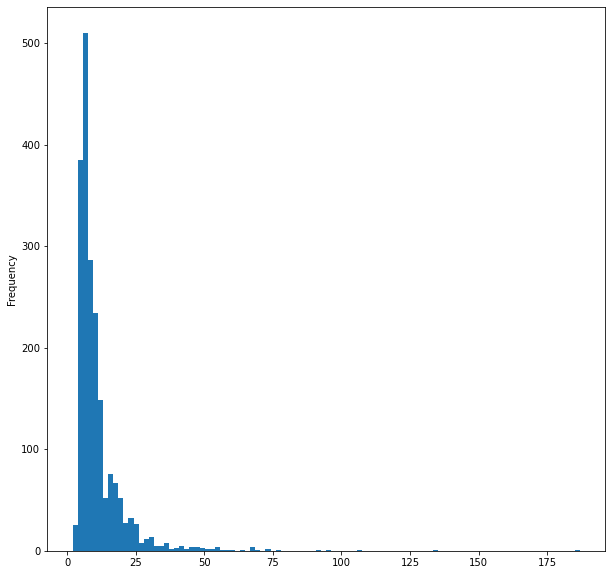

In [190]:
hope_test['token_count'].plot.hist(bins=100, alpha=1)

<AxesSubplot:ylabel='Frequency'>

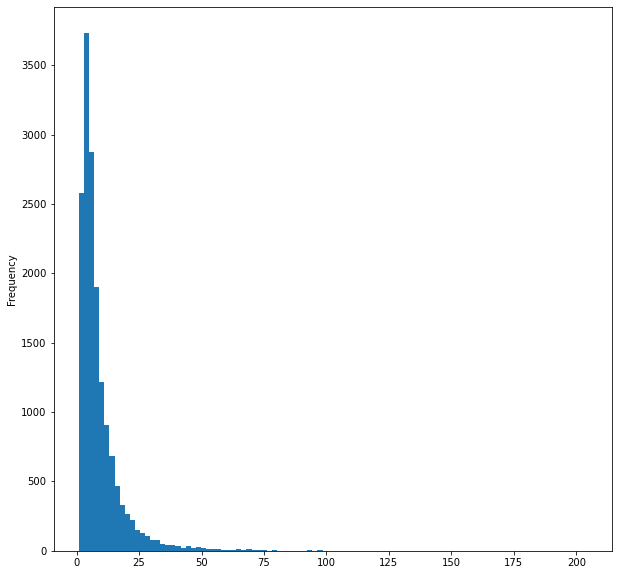

In [195]:
hope_train['token_count'].plot.hist(bins=100, alpha=1)

In [194]:
len(hope_train['token_count'].value_counts())

107

<AxesSubplot:ylabel='Frequency'>

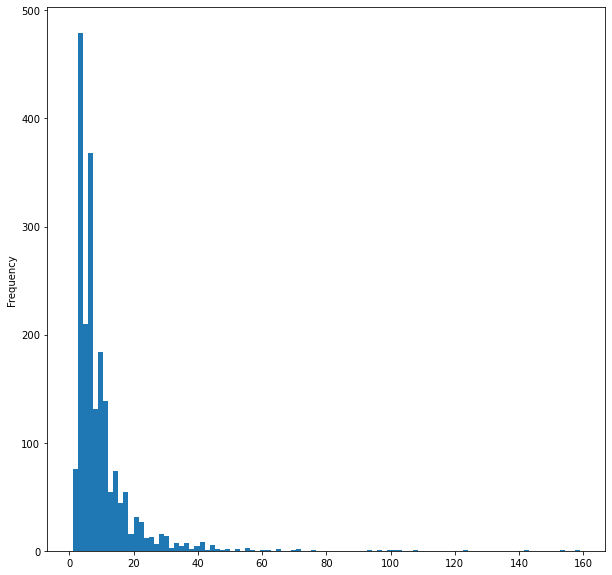

In [196]:
hope_dev['token_count'].plot.hist(bins=100, alpha=1)

In [202]:
hope_train.shape, hope_dev.shape, hope_test.shape

((16160, 3), (2018, 3), (2021, 3))

### Transliteration

In [208]:
hope_train['sentence'] = hope_train['sentence'].apply(lambda x: transliterator.transliterate(x, "en_US"))

In [209]:
hope_train

,sentence,label,token_count
0,Realme india product,not-Tamil,3
1,I also don't have tiktok hello and allnBut I'm...,Hope_speech,11
2,Thalaivare..neengale inum one plus mobile vach...,Non_hope_speech,11
3,Annee varanda thondai.. corona virus affect pa...,Hope_speech,20
4,5views but 18likes,Non_hope_speech,3
...,...,...,...
16155,7pm correcta erukum mg bro,Hope_speech,5
16156,Intha karutha mudija varaikum Neengalum ellark...,Non_hope_speech,10
16157,And neenga adhiyavasiyam nu soldra apps like t...,Non_hope_speech,20
16158,Daii sekram mater ku vada,Hope_speech,5


In [216]:
hope_train.to_csv(f"{BASE_DIR}/tamil_hope_full_train_transliterated.csv", index=False)

In [211]:
hope_dev['sentence'] = hope_dev['sentence'].apply(lambda x: transliterator.transliterate(x, "en_US"))

In [212]:
hope_dev

,sentence,label,token_count
0,Mg bro eve 6o clock video post pannuga,Hope_speech,9
1,8.00pm bro plss,not-Tamil,4
2,Bro ivan kitta sonna .Ivan change' pannidava ...,Hope_speech,10
3,@Varnajalam Mini Crafts adhum crrct thaan Akka 🤣,Non_hope_speech,8
4,ellaa kuzhanthaikalum nalla ennam,Hope_speech,4
...,...,...,...
2013,Share karo app use panlama,Non_hope_speech,5
2014,@R SWAGxOP kelattu kapothi maari nee pesathada...,Non_hope_speech,9
2015,Yow yaean yaa kelappi vidringa ipd,Non_hope_speech,6
2016,Hey bro. Ur doing amazing...,not-Tamil,7


In [218]:
hope_dev.to_csv(f"{BASE_DIR}/tamil_hope_full_dev_transliterated.csv", index=False)